<a href="https://colab.research.google.com/github/nisahmed25/defect-detection-using-similarity-check/blob/main/defectdetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

"Attached to this email are two images, good.png, and bad.png. The good.png file is an image of a metallic part without any defects and bad.png is a sample bad part. Note : attached bad part image is an example of nut missing defect. There can be different kinds of defects(like rust,dent etc.) present anywhere on the part.
The assignment is to come up with a deep-learning based solution that can differentiate b/w good and bad parts and clearly visualise the location of the defect. The solution should take into account that new types of defects are often discovered in the field and should be designed to incorporate new defects with as few changes as possible."

 PS: Mandatory points to remember
Use of the Deep Learning method is mandatory.
 Do the assignment in google colab and submit the link. This is to circumvent the version mismatch problem.

Explanation for the dataset provided:
Let me explain by giving an example of a smartphone. For the first case, imagine a smartphone which is not defective, i.e. good. Now there can be only one image of it. For the second case, i.e. defected case, there  can be an infinite number of ways in which defects can be introduced in smartphones. So we can never have a dataset of all the defects.

The problem statement of the assignment is similar. One good image has been given for the good part and for the bad part an example has been given as bad_image.png.

In [ ]:
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.applications.efficientnet import EfficientNetB3
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.layers import Input
from PIL import Image
import numpy as np
from skimage import transform

Create a function to read the image

In [ ]:
def read_image(file_path):
    img = cv2.imread(file_path)
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

Read our good and bad images. Upload good and bad pictues to present working directory in colab

In [ ]:
!pwd

/content


In [ ]:
goodimage = read_image('/content/good_image.png') #
badimage = read_image('/content/good_image.png') #

** approach**
# expectation: hardware object placed in same orientation everytime before the camera
 **Step 1**

In [ ]:
# generating feature representation of good image using a pretrained model.
# it will contain high level semantic information.

# use efficientnet model to extract final layer conv layer after global-average-pool
# result -> 10x10x1356 tensor for eff-B3 

base_model = EfficientNetB3(include_top=False,weights='imagenet',input_tensor=Input(shape=(300, 300, 3)))




43941888/43941136 [==============================] - 0s 0us/step


We will load the image using the below function

In [ ]:

def load(filename):
    np_image = Image.open(filename)
    np_image = np.array(np_image).astype('float32')
    np_image = transform.resize(np_image, (300, 300, 3))
    np_image = preprocess_input(np_image)
    np_image = np.expand_dims(np_image, axis=0)
    return np_image

In [ ]:
image = load('/content/good_image.png')
badimage = load('/content/bad_image.png')

tensor of the top layer is of 10x10x1536 shape. We will extract this feature vector of both images using *model.predict* 

In [ ]:
base_model.summary()


In [ ]:
pred = base_model.predict(image) #feature vector of good image

In [ ]:
pred_bad  = base_model.predict(badimage) # feature vector of bad image


We have to reshape this in order to find the similarity/difference

In [ ]:
pred = pred.reshape(100,1536) 
pred_bad = pred_bad.reshape(100,1536)

Inorder to find the **Similarity** we will import the cdist function from scipy

In [ ]:
from scipy.spatial.distance import cdist

In [ ]:
dist = np.diagonal(cdist(pred, pred_bad, 'cosine')).reshape(10,10)

If we generate heatmap of this, it will visualize the locations of similarities and difference of both images.
This heat map is saved to pwd.

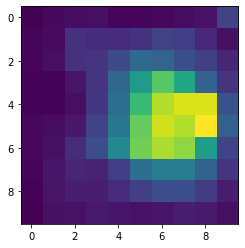

In [ ]:
plt.imshow(dist)
plt.show()
plt.imsave('/content/heat.png', dist)

The heat map shows a colour chang towards right, which indicates there's a difference towards right side of the second image with the first.

Inorder to visualize the location of the defect on bad image, we will blend the heat map on it. 

Let's do it using Image from PILLOW

In [ ]:
try:
    from PIL import Image
except ImportError:
    import Image

background = Image.open("/content/bad_image.png")
overlay = Image.open("/content/heat.png")
overlay

Resize both imagfe inorder to blend. Then blend it using Image.blend. And the new image is saved to pwd.

In [ ]:
background = background.resize((300,300))
overlay = overlay.resize((300,300))

In [ ]:
background = background.convert("RGBA")
overlay = overlay.convert("RGBA")

new_img = Image.blend(background, overlay, 0.5)
new_img.save("/content/new_test.png","PNG")

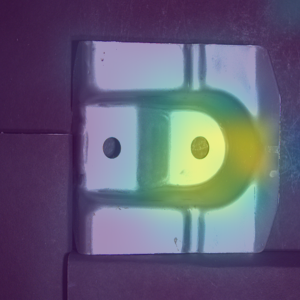

In [ ]:
new_img

Thus we have visualised the area of defect.

**# step 2**
This step is done in order to validate our method, so as to detect multiple defect cases and locations

Here we are doing cutout augumuntation. The paper link is given below.
 https://arxiv.org/abs/1708.04552 

 

In [ ]:
# assuming we have more number of bad images in real case
# generate augmented imges for bad images
# cut out aug to create more defected objects

def cutout(image, size=30, n_squares=1):
    h, w, channels = image.shape
    tmp_image = image.copy()
    for _ in range(n_squares):
        y = np.random.randint(h)
        x = np.random.randint(w)
        y1 = np.clip(y - size // 2, 0, h)
        y2 = np.clip(y + size // 2, 0, h)
        x1 = np.clip(x - size // 2, 0, w)
        x2 = np.clip(x + size // 2, 0, w)
        tmp_image[y1:y2,x1:x2,:] = 0.0
    return tmp_image
# generate same feature for all images



we are generating 10 cutout augumented images.

In [ ]:
ls = []
for _ in range(10):
    ls.append(cutout(goodimage))

In [ ]:
ls[1].shape

(480, 640, 3)

In [ ]:
plt.imsave('/content/ls1.jpg', ls[1])

In [ ]:
pred_good = base_model.predict(image) #feature vector of good image

Let's create a new function to load the cutout augumented bad images( by commenting the first line from our old load function)

In [ ]:
def load_ls(o):
#     np_image = Image.open(filename)
    np_image = np.array(o).astype('float32')
    np_image = transform.resize(np_image, (300, 300, 3))
    np_image = preprocess_input(np_image)
    np_image = np.expand_dims(np_image, axis=0)
    return np_image

In [ ]:
pred_ls1 = base_model.predict(load_ls(ls[1]))

In [ ]:
pred_good = pred_good.reshape(100,1536)
pred_ls1= pred_ls1.reshape(100,1536)

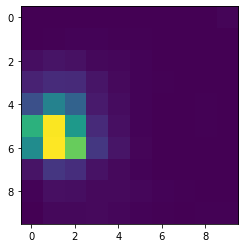

In [ ]:
plt.imshow(np.diagonal(cdist(pred_good, pred_ls1, 'cosine')).reshape(10,10))
plt.imsave('/content/heat_cutout.jpg', np.diagonal(cdist(pred_good, pred_ls1, 'cosine')).reshape(10,10))

The heat map is blended on the respective cutout image

In [ ]:
try:
    from PIL import Image
except ImportError:
    import Image

background = Image.open("/content/ls1.jpg")
overlay = Image.open("/content/heat_cutout.jpg")


In [ ]:
background = background.resize((300,300))
overlay = overlay.resize((300,300))


In [ ]:
background = background.convert("RGBA")
overlay = overlay.convert("RGBA")

cutout_img = Image.blend(background, overlay, 0.5)
cutout_img.save("cutoutvalidation.png","PNG")

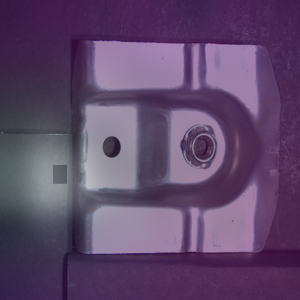

In [ ]:
cutout_img


This method is accurate if both the hardware are kept identically.